In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
from transformers import LongformerModel, LongformerTokenizer
import os
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import logging

In [2]:
import wandb

In [3]:

# Inizializza wandb
wandb.login()
wandb.init(project="multilayer_long", entity="raffalo8888")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: raffalo8888. Use `wandb login --relogin` to force relogin


In [4]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [3]:
from torch.nn import BCEWithLogitsLoss
from transformers import LongformerTokenizerFast, \
LongformerModel, LongformerConfig, Trainer, TrainingArguments, EvalPrediction, AutoTokenizer
from transformers.models.longformer.modeling_longformer import LongformerPreTrainedModel, LongformerClassificationHead
from torch.utils.data import Dataset, DataLoader
import random




### Aggiunta di un layer di classificazione al longformer

In [4]:

class LongformerForMultiLabelSequenceClassification(LongformerPreTrainedModel):
  

    def __init__(self, config):
        super(LongformerForMultiLabelSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels
        self.longformer = LongformerModel(config)
        self.classifier = LongformerClassificationHead(config)
        self.init_weights()
    def forward(self, input_ids=None, attention_mask=None, global_attention_mask=None,
                token_type_ids=None, position_ids=None, inputs_embeds=None,
                labels=None):

        if global_attention_mask is None:
            global_attention_mask = torch.zeros_like(input_ids)
            global_attention_mask[:, 0] = 1

        
        outputs = self.longformer(
            input_ids = input_ids,
            attention_mask = attention_mask,
            global_attention_mask = global_attention_mask,
            token_type_ids = token_type_ids,
            position_ids = position_ids)

        
        sequence_output = outputs['last_hidden_state']

        logits = self.classifier(sequence_output)
        outputs = (logits,) + outputs[2:]
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            labels = labels.float()
            loss = loss_fct(logits.view(-1, self.num_labels),
                            labels.view(-1, self.num_labels))
            outputs = (loss,) + outputs


        return outputs



In [146]:
k_neighbour = pd.read_csv("/kaggle/input/k-neighb/dataset_k_neighbour.csv")


### Trasformazione delle classi in vettori oneHot

In [150]:
from sklearn.preprocessing import OneHotEncoder

df = k_neighbour.drop(columns=['df_index', 'lunghezza_testo'])
df['ID'] = range(0, len(df) )

encoder = OneHotEncoder(sparse=False)  
categories_onehot = encoder.fit_transform(df[['Category']])  

df['Category_OneHot'] = list(categories_onehot)

# 0 buss 1 other  2 politc 3 sport 4 tech 
df


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Text,Category,ID,Category_OneHot
0,AP - Kobe Bryant can go on as a basketball sup...,sport,0,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,AP - Jerry Rice returned to the practice field...,sport,1,"[0.0, 0.0, 0.0, 1.0, 0.0]"
2,AP - In a candid interview with his time in of...,politics,2,"[0.0, 0.0, 1.0, 0.0, 0.0]"
3,"Nokia Corp., the world 39;s largest mobile pho...",business,3,"[1.0, 0.0, 0.0, 0.0, 0.0]"
4,Nairobi - Kenya 39;s fight against corruption ...,politics,4,"[0.0, 0.0, 1.0, 0.0, 0.0]"
...,...,...,...,...
53663,The US Federal Trade Commission filed a legal ...,tech,53663,"[0.0, 0.0, 0.0, 0.0, 1.0]"
53664,"Blogs are the hottest thing on the Net, but ar...",business,53664,"[1.0, 0.0, 0.0, 0.0, 0.0]"
53665,Sprint 39;s acquisition of Nextel Communicatio...,business,53665,"[1.0, 0.0, 0.0, 0.0, 0.0]"
53666,The state's highest court affirmed an already ...,business,53666,"[1.0, 0.0, 0.0, 0.0, 0.0]"


### Dataloader

In [14]:
class Data_Processing(object):
    def __init__(self, tokenizer, dataframe):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        # Nomi delle colonne codificati direttamente nella classe
        self.text_column_name = 'Text'  # Sostituisci con il nome effettivo della colonna
        self.label_column_name = 'Category_OneHot'  # Sostituisci con il nome effettivo della colonna

    def __getitem__(self, idx):
        # Accede direttamente alla riga del DataFrame utilizzando l'indice
        row = self.dataframe.iloc[idx]

        comment_text = str(row[self.text_column_name])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            add_special_tokens=True,
            max_length=1024,
            padding='max_length',
            return_attention_mask=True,
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze()  # Rimuove l'eventuale dimensione extra
        attention_mask = inputs['attention_mask'].squeeze()
        labels_ = torch.tensor(row[self.label_column_name], dtype=torch.float)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels_,
            'id_': row.name  # `row.name` contiene l'indice della riga
        }

    def __len__(self):
        return len(self.dataframe)

 
    
batch_size = 2

In [5]:
tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096',padding = 'max_length',truncation=True,max_length = 1024)

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [111]:

from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(df.sample(20000), test_size=0.1, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)

train_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)
val_dataset.reset_index(drop=True, inplace=True)



tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096',padding = 'max_length',truncation=True,max_length = 1024)

train_dataset
train_dataset.to_csv("/kaggle/working//train_data_csv")
test_dataset.to_csv("/kaggle/working/test_data_csv")
val_dataset.to_csv("/kaggle/working/val_data_csv")
training_data = Data_Processing( tokenizer=tokenizer,dataframe=train_dataset )
test_data = Data_Processing( tokenizer=tokenizer,dataframe=test_dataset )
val_data = Data_Processing( tokenizer=tokenizer,dataframe=val_dataset )


dataloaders_dict = {'train': DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4),
                    'val': DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4),
                    'test': DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
                    
                   }

dataset_sizes = {'train':len(training_data),
                 'val':len(test_data),
                 'test':len(test_data)
                }




NameError: name 'df' is not defined

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Instanza del modello , passiamo il numero di classi e la finestra di attenzione 

In [6]:
model = LongformerForMultiLabelSequenceClassification.from_pretrained('allenai/longformer-base-4096',
                                                  gradient_checkpointing=False,
                                                  attention_window = 512,
                                                  num_labels = 5,
                                                  return_dict=True)


pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of LongformerForMultiLabelSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Metriche 

In [ ]:

def multi_label_metrics(
    predictions,
    labels,
    ):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.zeros(probs.shape)
    y_true = labels
    y_pred[np.where(probs >= 0.5)] = 1
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)
    return result


### Allenamento

In [15]:

from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    output_dir='kaggle/working/results', 
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/kaggle/working/logs',
    logging_strategy="steps",
    logging_steps=50, 
    save_strategy="epoch", 
    evaluation_strategy="epoch",  
    load_best_model_at_end=True
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_data,  
    eval_dataset=val_data,  
    compute_metrics=compute_metrics,  
)

trainer.train()

device = 'cuda' if torch.cuda.is_available() else 'cpu'




Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.170800,0.183865,0.874375,0.921319,0.873889
2,0.183000,0.189403,0.869541,0.918056,0.868333
3,0.163900,0.167383,0.876047,0.921042,0.871667
4,0.145500,0.181163,0.879666,0.923958,0.877222
5,0.092700,0.168075,0.883380,0.922917,0.871111


In [16]:
model.save_pretrained("./best_model")

trainer.evaluate()
test_results = trainer.predict(test_data)


{'eval_loss': 0.16738289594650269,
 'eval_f1': 0.8760469011725294,
 'eval_roc_auc': 0.9210416666666666,
 'eval_accuracy': 0.8716666666666667,
 'eval_runtime': 123.5251,
 'eval_samples_per_second': 14.572,
 'eval_steps_per_second': 3.643,
 'epoch': 5.0}

In [ ]:
predictions = trainer.predict(training_data)


probabilities = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)


predicted_labels = np.argmax(probabilities, axis=1)

### Fase di Test

In [33]:
test_dataset = pd.read_csv("/kaggle/working/test_data_csv")
train_dataset = pd.read_csv("/kaggle/working//train_data_csv")
training_data = Data_Processing( tokenizer=tokenizer,dataframe=train_dataset )
test_data = Data_Processing( tokenizer=tokenizer,dataframe=test_dataset )

val_dataset = pd.read_csv("/kaggle/working/val_data_csv")
val_data = Data_Processing( tokenizer=tokenizer,dataframe=val_dataset )


In [7]:
model = LongformerForMultiLabelSequenceClassification.from_pretrained("/kaggle/working/best_model")

In [8]:
test  = pd.read_csv("/kaggle/input/longformere/dataset_Longformer.csv")

In [9]:
category_to_index = {'business': 0, 'other': 1, 'politics': 2, 'sport': 3, 'tech': 4}
num_categories = len(category_to_index)

In [10]:
def category_to_onehot(category):
    one_hot = np.zeros(num_categories)
    one_hot[category_to_index[category]] = 1
    return one_hot

test['One_Hot_Category'] = test['Category'].apply(category_to_onehot)


test

,Text,Category,df_index,lunghezza_testo,One_Hot_Category
0,A new Internet advertising forecast shows a sl...,business,3,167,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1,Shares in animation giant Pixar set new record...,business,3,104,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2,LAGOS (AFP) - The Nigerian Labour Congress (NL...,politics,3,241,"[0.0, 0.0, 1.0, 0.0, 0.0]"
3,AP - Orders to U.S. factories for big-ticket g...,business,3,145,"[1.0, 0.0, 0.0, 0.0, 0.0]"
4,A military court sentenced Staff Sgt. Ivan Fre...,politics,3,161,"[0.0, 0.0, 1.0, 0.0, 0.0]"
...,...,...,...,...,...
80495,BAGHDAD -- US troops sweeping through Fallujah...,politics,3,275,"[0.0, 0.0, 1.0, 0.0, 0.0]"
80496,InfoWorld - The Object Management Group (OMG) ...,tech,3,360,"[0.0, 0.0, 0.0, 0.0, 1.0]"
80497,"Payless ShoeSource beats analyst estimates, bu...",business,3,75,"[1.0, 0.0, 0.0, 0.0, 0.0]"
80498,IRAQS national election campaign kicked off ye...,politics,3,197,"[0.0, 0.0, 1.0, 0.0, 0.0]"


In [338]:
test.to_csv("test_longformer_one_hot.csv",index = False)

### DataLoader

In [11]:
class PredictionDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(
            text, 
            return_tensors="pt", 
            padding="max_length", 
            truncation=True, 
            max_length=self.max_length
        )
        # Trasformare il dizionario in un formato che non ha la dimensione del batch
        return {key: value.squeeze(0) for key, value in inputs.items()}
    

In [35]:
test_dataset_for_evaluation = test.head(10000)
    
prediction_dataset = PredictionDataset(texts=test_dataset_for_evaluation["Text"].tolist(), tokenizer=tokenizer, max_length=1024)
prediction_dataloader = DataLoader(prediction_dataset, batch_size=16, shuffle=False)


In [37]:
model.eval()  
predictions = []
model.to(device)
with torch.no_grad():
    for batch in prediction_dataloader:

        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Aggiungi qui la logica per la global_attention_mask se necessario
        global_attention_mask = torch.zeros_like(batch['input_ids'])
        global_attention_mask[:, 0] = 1  
        global_attention_mask = global_attention_mask.to(device)
        

        outputs = model(**batch, global_attention_mask=global_attention_mask)
        batch_predictions = torch.nn.functional.softmax(outputs[0], dim=-1)
        
        predictions.append(batch_predictions.cpu())


predictions = torch.cat(predictions, dim=0)


predicted_class_ids = torch.argmax(predictions, axis=1).numpy()


In [38]:
true_label_test  = test_dataset_for_evaluation["One_Hot_Category"]

In [39]:

labels = ['business', 'other', 'politics', 'sport', 'tech']

labels_index = [category_to_index[label] for label in labels]
num_classes = 5  


predicted_one_hot = np.eye(num_classes)[predicted_class_ids]
true_one_hot = np.array(true_label_test)
true_one_hot_2d = np.array(true_one_hot)
true_one_hot_2d = np.vstack(true_one_hot_2d)

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

true_labels = np.argmax(true_one_hot_2d, axis=1)
predicted_labels = np.argmax(predicted_one_hot, axis=1)


accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')


precision = precision_score(true_labels, predicted_labels, average='macro')
print(f'Precision: {precision}')


recall = recall_score(true_labels, predicted_labels, average='macro')
print(f'Recall: {recall}')

f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'F1 Score: {f1}')


Accuracy: 0.8855
Precision: 0.8733823671767708
Recall: 0.8545310655127955
F1 Score: 0.8624454104026953


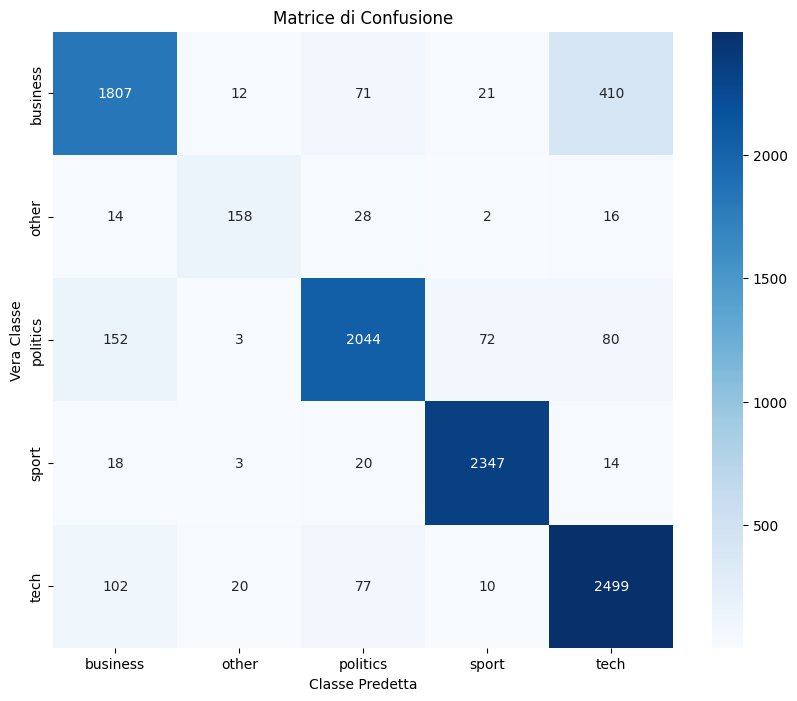

In [41]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
matrice_confusione = confusion_matrix(true_labels, predicted_labels)


classi = ['business', 'other', 'politics', 'sport', 'tech']


plt.figure(figsize=(10, 8))
sns.heatmap(matrice_confusione, annot=True, fmt="d", cmap="Blues", xticklabels=classi, yticklabels=classi)


plt.title('Matrice di Confusione')
plt.ylabel('Vera Classe')
plt.xlabel('Classe Predetta')


plt.show()

In [352]:
text = "We ve just seen deputy PM Oliver Dowden tells MPs that China is responsible for malicious cyber campaigns targeting the Electoral Commission and MPs. The sheer size of this hack on the Electoral Commission was eye watering – 40 million people affected. But as ever with cyber-attacks, it’s the quality of data that’s more important than quantity. On that metric it was still one of the most significant hacks in history for the British public. Databases containing the names and addresses of all registered voters were able to be read and copied by hackers.The Electoral Commission played it down at the time arguing that the data was already largely in the public domain. However, it transpired that more than half of the data – so tens of millions of records weren’t publicly available at all. So make no mistake – this could have put a vast amount of private data into the hands of cyber criminals (we still don’t know if they actually did access them).However, due to the nature of this hack – for espionage, not money – the accessed data of the general public is probably less important to Chinese cyber spies. It’s likely that having been able to read the toing and froing of sensitive emails between election officials for over a year during six by-elections would have been far more valuable.No specific briefing for Tory 1922 committee - deputy PM Dowden is back on his feet insisting the UK will do what is necessary to protect the UK's systems as he answers a couple of questions raised by Labour's Pat McFadden. He says Foreign Secretary Lord Cameron s past and present relations and links with China will have been the subject of usual scrutiny. Dowden explains that the former prime minister David Cameron is due to speak to the Conservative backbench group, known as the 1922 Committee, later today on a range of issues - distancing it from a specific briefing on what has been announced this afternoon. Finally, Dowden insists should leaders of the opposition or any other Westminster party wish to have a particular briefing on this matter, then he will make himself available to do so in the normal way. "
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Aggiunta della global_attention_mask
global_attention_mask = torch.zeros_like(inputs['input_ids'])
# Supponendo che vuoi la global attention sul primo token
global_attention_mask[:, 0] = 1

# Assicurati che tutto sia sul dispositivo giusto (ad esempio, cuda se disponibile)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = {k: v.to(device) for k, v in inputs.items()}
global_attention_mask = global_attention_mask.to(device)

# Esegui la predizione
with torch.no_grad():
    outputs = model(**inputs, global_attention_mask=global_attention_mask)
    predictions = torch.nn.functional.softmax(outputs[0], dim=-1)
predicted_class_id = np.argmax(predictions.cpu(), axis=1)
predicted_class_id

tensor([4])

In [1]:
!zip -r file.zip /kaggle/working
from IPython.display import FileLink
FileLink(r'file.zip')

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/kaggle/ (stored 0%)
  adding: kaggle/working/kaggle/working/ (stored 0%)
  adding: kaggle/working/kaggle/working/results/ (stored 0%)
  adding: kaggle/working/kaggle/working/results/checkpoint-12150/ (stored 0%)
  adding: kaggle/working/kaggle/working/results/checkpoint-12150/scheduler.pt (deflated 56%)
  adding: kaggle/working/kaggle/working/results/checkpoint-12150/optimizer.pt (deflated 20%)
  adding: kaggle/working/kaggle/working/results/checkpoint-12150/rng_state.pth (deflated 25%)
  adding: kaggle/working/kaggle/working/results/checkpoint-12150/training_args.bin (deflated 51%)
  adding: kaggle/working/kaggle/working/results/checkpoint-12150/config.json (deflated 58%)
  adding: kaggle/working/kaggle/working/results/checkpoint-12150/trainer_state.json (deflated 83%)
  adding: kaggle/working/kaggle/working/results/checkpoint-12150/model.safetensors (deflated 9%)
  adding: kaggle/working/kaggle/working/results/checkpoint-

/kaggle/working/file.zip

In [217]:
import os
os.listdir()

['train_data_csv',
 'kaggle',
 'file.zip',
 'val_data_csv',
 '.virtual_documents',
 'wandb',
 'logs',
 'test_data_csv',
 'best_model',
 'state.db']

In [222]:
os.remove("file.zip")

In [221]:
!zip -r file.zip /kaggle/working/logs
from IPython.display import FileLink
FileLink(r'file.zip')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/logs/ (stored 0%)
  adding: kaggle/working/logs/events.out.tfevents.1711309743.ca832499b7bb.34.1 (deflated 63%)
  adding: kaggle/working/logs/events.out.tfevents.1711309758.ca832499b7bb.34.2 (deflated 70%)
  adding: kaggle/working/logs/events.out.tfevents.1711331162.ca832499b7bb.34.3 (deflated 31%)
  adding: kaggle/working/logs/events.out.tfevents.1711309738.ca832499b7bb.34.0 (deflated 63%)


/kaggle/working/file.zip